In [1]:
# notebook last tested with abtem version 1.0.0beta32
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mimg

import cv2
import random

import numpy as np
import numpy.ma as ma
import pandas as pd
import shutil
import os

from scipy import constants
from scipy import misc
from scipy.ndimage import gaussian_filter

from abtem import __version__
from abtem import *

from ase.io import read
from ase.cluster import wulff_construction
from ase import Atoms
import ase.data



from PIL import Image
from skimage import data
from skimage import filters
from skimage import exposure
from skimage.filters import gaussian

/zhome/ab/7/153983/project/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [107]:
# Function that creates a custom sized circle mask at given h,w
def create_circular_mask(h, w, center=None, radius=None):
    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
        
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((Y - center[0])**2 + (X-center[1])**2)

    mask = dist_from_center <= radius
    return mask

# Function that applies mask on the image
def apply_mask(img):
    image = Image.open(img)
    image_arr = np.array(image)

    if image_arr.shape[-1] == 4:
        image_arr = image_arr[:,:,:-1]

    image_arr = image_arr.astype(float)
    image_arr /= 255

    if len(image_arr.shape) == 3:
        weights = np.array([1, 1, 1])
        image_arr = np.dot(image_arr, weights)

    image_center = (300, 400)
    image_center_arr = np.array(image_center)
    inner_mask = create_circular_mask(600 ,800 ,
                                      center = image_center_arr, radius = 100)
    visible_mask = create_circular_mask(600 ,800 ,
                                      center = image_center_arr, radius = 250)
    visible_mask = np.logical_xor(visible_mask, inner_mask)
    
    # Apply mask and return 
    
    return ma.masked_array(image_arr, ~visible_mask)


# Function that applies mask on the image
def apply_varrying_mask(img, white_mask = True):
    # open image
    image = Image.open(img)
    image_arr = np.array(image)

    # reduce dimentions
    if image_arr.shape[-1] == 4:
        image_arr = image_arr[:,:,:-1]

    # turn inot float and scale 0 to 1
    image_arr = image_arr.astype(float)
    image_arr /= 255

    # make black&white if necessary
    if len(image_arr.shape) == 3:
        weights = np.array([1, 1, 1])
        image_arr = np.dot(image_arr, weights)
    
    
    offset_x = random.randint(0,20)
    offset_y = random.randint(0,20)
    
    image_center = (290 + offset_y, 390 + offset_x)
    image_center_arr = np.array(image_center)
    inner_mask = create_circular_mask(600 ,800 ,
                                      center = image_center_arr, radius = 110)
    visible_mask = create_circular_mask(600 ,800 ,
                                      center = image_center_arr, radius = 250)
    visible_mask = np.logical_xor(visible_mask, inner_mask)
    
    
    # Apply mask 
    masked = ma.masked_array(image_arr, ~visible_mask)
    result = masked[40 + offset_y: 540 + offset_y, 140 + offset_x: 640 + offset_x]
    if white_mask:
        return result
    else:
        return np.where(~result.mask, result.data, 0)

In [113]:
# generate csv file with all the image paths
def generate_path_csv(image_dir = "images_800x600", name='lables.csv'):
    folders = ["train", "test", "valid"]
    image_paths = []
    for folder in folders:
        l = os.listdir('Database/{}/{}'.format(image_dir, folder))
        for image in l:
            euler = image.split("_")
            phi1 = float(euler[1])
            PHI  = float(euler[2])
            phi2 = float(euler[3][:-4])
            image_paths.append(['Database/{}/{}/{}'.format(image_dir, folder, image), image, phi1, PHI, phi2])

    df = pd.DataFrame(image_paths, columns =['ImagePath', 'image_name','phi1','PHI','phi2'])    
    df.to_csv(name)  

In [129]:
def preprocessImages(input_dir = "cleanImg", output_dir = "default", white_background = True, csv_name=None):
    output_path = 'Database/{}'.format(output_dir)
    input_path  = 'Database/{}'.format(input_dir)
    if not os.path.exists(output_path):      
        # create given directories
        os.mkdir(output_path)
        for directory in ["train", "test", "valid"]:
             os.mkdir("{}/{}".format(output_path, directory))
        
        # get all the image names
        l = os.listdir(input_path)
        image_paths = []
        
        # make split between train, test adn validation sets
        for i in range(len(l)):
            # output progress          
            if i % 1000 == 0:
                      print("{} images generated".format(i))
                      
            if i < 1000:
                directory = "valid"
            elif i < 2000:
                directory = "test"
            else:
                directory = "train"
      
            # apply mask
            img = apply_varrying_mask("{}/{}".format(input_path, l[i]), white_mask = white_background)
                      
            # get euler angles from name
            euler = l[i].split("_")
            phi1 = float(euler[1])/90
            PHI  = float(euler[2])/90
            phi2 = float(euler[3][:-4])/90
            
            # append new image ingo to list
            image_path = "{}/{}/{}".format(output_path, directory, l[i])
            image_paths.append([image_path, phi1, PHI, phi2])
                      
            # save current image
            mimg.imsave(image_path, img, cmap = 'gray')        
        # save csv if name is given
        if csv_name != None:
            generate_path_csv(image_dirctory = output_dir, name=csv_name)
        
        print("Finished!")
    else:
        print("Folder [{}] already exists".format(output_dir))

In [130]:
# Execute code
preprocessImages(output_dir = "black_background_500x500", white_background = False, csv_name="black_background_500x500.csv")

0 images generated
1000 images generated
2000 images generated
3000 images generated
4000 images generated
5000 images generated
6000 images generated
7000 images generated
8000 images generated
9000 images generated
10000 images generated


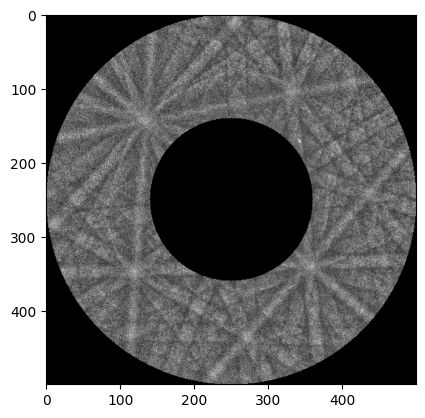

In [146]:
image = Image.open("{}/{}/{}".format("Database", "black_background_500x500/train", l[9000]))
plt.imshow(image, cmap="gray")

In [139]:
i

3